In [1]:
import numpy as np
import re
import random
import itertools
import datetime

import tensorflow as tf
import sklearn as sk
import colorama as col

from gensim.models import Word2Vec

import Functions as fn
from DS import DS
from Set import pool
from Iterator import Iterator
from FFModel import FF_Model
from RNNModel import RNN_Model

C:\Users\Luka\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('labels')

Label Load Complete


# Embedding Generation

In [4]:
#Dataset.process_for_embedding()
#sentences = Dataset.get_sentences()
#fn.write_sentences('sentences')
sentences = fn.load_sentences('sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('W2V')
model = Word2Vec.load('W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Layer and Index Loading

In [5]:
#word_indices, emb_layer = fn.get_index_and_emb_layer(model)
#fn.write_word_indices(word_indices, 'word_indices')
#fn.write_emb_layer(emb_layer, 'emb_layer')

word_indices = fn.load_word_indices('word_indices')
emb_layer = fn.load_emb_layer('emb_layer')

Word Indices Load Complete
Embedding Layer Load Complete


# RNN Testing

In [6]:
train_cases = pool((Dataset.get_DS(stage='test', labelled='yes')).data[:-25])
validation_cases = pool(Dataset.get_DS(stage='test', labelled='yes').data[-25:])
test_cases = Dataset.get_DS(stage='train', labelled='yes')

train_cases.process_for_testing()
validation_cases.process_for_testing()
test_cases.process_for_testing()

In [7]:
lw, rw = 3, 3
sets = {}
sets['train_set'], sets['train_labels'], _ = train_cases.get_rnn_sets(word_indices, left_words=lw, right_words=rw)
sets['validation_set'], sets['validation_labels'], _ = validation_cases.get_rnn_sets(word_indices, left_words=lw, right_words=rw)
sets['test_set'], sets['test_labels'], sets['test_words'] = test_cases.get_rnn_sets(word_indices, left_words=lw, right_words=rw)

In [8]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set_training(sets['train_set'], sets['train_labels'], 0.1)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.05% non-med: 0.95%
Ratio: med: 0.13% non-med: 0.87%


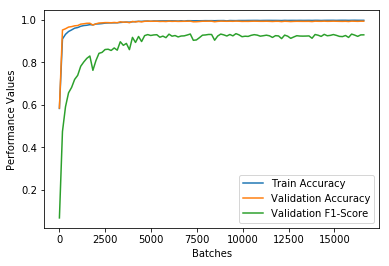

FInal Values: TrAcc: 0.998, ValAcc: 0.994, ValF1: 0.930
Test F1-Score: 0.943



In [9]:
RNN = RNN_Model(vocab_size=len(word_indices), state_size=100, num_classes=2, window=7, learn_rate=0.001, emb_layer=emb_layer)
RNN.build_graph()
_, _, _, _, = RNN.train(sets=sets, epochs=3, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [10]:
res = RNN.sess.run(RNN.graph['prediction'], feed_dict = {RNN.graph['x']: sets['test_set'],
                                                         RNN.graph['y']: np.argmax(sets['test_labels'], 1),
                                                         RNN.graph['keep_prob']: 1.0})
tru = np.argmax(sets['test_labels'], 1)

In [12]:
_ = fn.token_perf(res, tru)

TP	TN	FP	FN
484	10618	27	32

Precision: 0.9472
Recall: 0.9380
F1-Score: 0.9426


In [15]:
baseline = [0 if word in target_dict['medications'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.3458814759597465

In [13]:
sets['test_words'] = [word for case in test_cases.data for word in case.test_text]

In [16]:
fn.category_words(sets['test_words'], res, tru, 0, 1)

regular, oxygen, permsan, home, medications, tylenol, micro, aspirin, anticoagulation, regimen, flagyl, monday-wednesday-friday, regimen, monday-wednesday-friday, hcl, topical, tp, riss, home, meds, motrin, cardiac, regimen, ppi, iss, other, medications


In [18]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [22]:
TP, FP, FN = 0, 0, 0
testers = Dataset.get_DS(stage='train', labelled='yes')

for i in range(testers.size):
    current_ds = pool(data=[testers.data[i]])
    #current_ds.show_info()
    current_ds.process_for_testing()
    cur_set, cur_lab, _ = current_ds.get_rnn_sets(word_indices=word_indices, left_words=3, right_words=3)
    cur_words = [word for case in current_ds.data for word in case.test_text]
    
    cur_res = RNN.sess.run(RNN.graph['prediction'], feed_dict = {RNN.graph['x']: cur_set,
                                                                 RNN.graph['y']: np.argmax(cur_lab, 1),
                                                                 RNN.graph['keep_prob']: 1.0})
    cur_tru = np.argmax(cur_lab, 1)
    
    #for j in range(len(cur_res)):
    #    if (cur_words[j] == ')' or cur_words[j] == '('):
    #        cur_res[j] = 1
    #        cur_tru[j] = 1
            
    res_words = set()
    tru_words = set()
    res_inside = False
    tru_inside = False
    res_med = ''
    tru_med = ''
    for k in range(len(cur_words)):
        if not res_inside:
            if cur_res[k] == 0:
                res_med = cur_words[k]
                res_inside = True
        else:
            if cur_res[k] == 0:
                res_med = res_med + ' ' + cur_words[k]
            else:
                res_words.add(res_med)
                res_med = 0
                res_inside = False

        if not tru_inside:
            if cur_tru[k] == 0:
                tru_med = cur_words[k]
                tru_inside = True
        else:
            if cur_tru[k] == 0:
                tru_med = tru_med + ' ' + cur_words[k]
            else:
                tru_words.add(tru_med)
                tru_med = 0
                tru_inside = False
    
    print(', '.join([col.Back.YELLOW + word + col.Back.RESET if word not in tru_words else word for word in res_words]) + '\n')
    print(', '.join([col.Back.RED + word + col.Back.RESET if word not in res_words else word for word in tru_words]) + '\n')
    
    TP += len([1 for med in res_words if med in tru_words])
    FP += len([1 for med in res_words if med not in tru_words])
    FN += len([1 for med in tru_words if med not in res_words])

print('TP\tFP\tFN\n{}\t{}\t{}'.format(TP, FP, FN))
print('F1-score: {:.4f}'.format((2 * TP) / ( 2 * TP + FP + FN)))

zestril, colace, heparin, insulin nph, axid, insulin lente, insulin, antibiotics, coumadin, ecotrin, lopressor, vancomycin, isordil, regular, percocet, ofloxacin

zestril, colace, insulin, heparin, axid, insulin lente, insulin nph, antibiotics, coumadin, ecotrin, lopressor, vancomycin, isordil, urokinase, percocet, ofloxacin

ciprofloxacin, baby aspirin, insulin, oxygen, toprol-xl, aspirin, metformin, lantus, lasix, atenolol, novolog, motrin, humalog insulin, beta-blocker, potassium chloride slow release

ciprofloxacin, baby aspirin, insulin, toprol-xl, aspirin, metformin, lantus, lasix, atenolol, novolog, motrin, humalog insulin, beta-blocker, epinephrine, nasal cannula, potassium chloride slow release, precedex

heparin, lipitor, neurontin, glucophage, permsan, zocor, percocet, celexa, ace inhibitor, captopril, home medications, aspirin, klonopin, zestril, tylenol, lopressor, beta-blocker, lovenox, atenolol, nitroglycerin, packed red blood cells, plavix

heparin, lipitor, neurontin, 

# HyperParameter Scan

In [ ]:
emb_sizes = [100]
emb_models = 1
target_saturations = [0.05, 0.1, 0.2, 0.5, 0.7]
layer_sizes = [50]
dropouts = [1.0]
learn_rates = [0.01]
epochs = [100]
NN_num = 5

case_num = len(emb_sizes)*emb_models*len(layer_sizes)*len(target_saturations)*len(epochs)*len(dropouts)*len(learn_rates)*NN_num
print(case_num)

In [ ]:
max_performance = 0
n = 1

for emb_size in emb_sizes:
    print('Model Number: %d/%d' %(n, case_num))
    for i in range(emb_models):
        model = Word2Vec(sentences, min_count=1, size=emb_size)
        for saturation in target_saturations:
            sets = fn.get_traintest2 (labelled_cases, model)
            fn.saturate_training_set(sets, model, target_dict['medications'], saturation)
            for layer_size in layer_sizes:
                for drop in dropouts:
                    for rate in learn_rates:
                        for epoch in epochs:
                            for j in range(NN_num):
                                print('Model Number: %d/%d' %(n, case_num))
                                print('ES: %d EM: %d sat: %f, LS: %d, drop: %f, LR: %f, epochs: %d, NN: %d' \
                                       % (emb_size, i, saturation, layer_size, drop, rate, epoch, j))
                                NN = FF_Model(input_size=emb_size, layers=[layer_size], dropout=drop, learn_rate=rate)
                                NN.build_graph()
                                NN.train(sets, epochs=epoch)
                                res = NN.predict(sets['test_set'])
                                tru = np.argmax(sets['test_labels'], 1)
                                perf = sk.metrics.f1_score(tru, res, pos_label=0)
                                if perf > max_performance:
                                    max_performance = perf
                                    NN.save_model('gold')
                                    model.save('gold/GOLDEMB')
                                NN.close()
                                n += 1